In [1]:
# load dataset
import pandas as pd
df = pd.read_csv("/Users/bhavnabangia/Downloads/ArSarcasm_train.csv")
df.head()

,dialect,sarcasm,sentiment,original_sentiment,tweet,source
0,gulf,False,negative,negative,"""نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...",semeval
1,msa,False,neutral,positive,"""#نادين_نسيب_نجيم ❤️❤️❤️مجلة #ماري_كلير 💭#ملكة...",semeval
2,egypt,False,neutral,neutral,"""@Alito_NBA اتوقع انه بيستمر""",semeval
3,levant,True,neutral,negative,"""@KSA24 يعني ""بموافقتنا"" لأن دمشق صايرة موسكو""",semeval
4,msa,False,neutral,negative,"""RT @alaahmad20: قائد في الحرس يعترف بفقدان ال...",semeval


In [2]:
# cleaning text (removing special keywords, emojies, stopwords,links, urls, users etc)
import re

def clean_tweet(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove emails
    text = re.sub(r'\S*@\S*\s?', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Convert text to lowercase
    text = text.lower()
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Remove hashtags
    text = re.sub(r'#\S+', '', text)
    
    return text

# Example usage
clean_tweet('"نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش❤️❤️❤️مجلة 💭 👑 زي ما كنّا متوقعين الله يرحم ايامات السيقا والفاميلي #SuperMarioRun  https//  noor@gmail.com @all"')
df['clean_tweet'] = df['tweet'].apply(clean_tweet)

In [3]:
df['clean_tweet']

0       "نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما ...
1                                         " ❤️❤️❤️مجلة   
2                                       اتوقع انه بيستمر"
3                  يعني "بموافقتنا" لأن دمشق صايرة موسكو"
4       "rt قائد في الحرس يعترف بفقدان السيطرة الأمنية...
                              ...                        
8432    "rt  | تطبيق يوتيوب الأطفال من جوجل يعرض المقا...
8433    سي بي سي: يشارك باحتفالية تنزانيا اليوم بمناسب...
8434    "كلب إسرائيل وسيفها الإرهابي بوتن قاتل النساء ...
8435    "احمد فتفت صار مغضوب عليه بمجرد اعترضو على ميش...
8436    "قناة آسيا: مندوب  في  بشار الجعفري:  في  هو ن...
Name: clean_tweet, Length: 8437, dtype: object

In [4]:
# Encoding 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()

df['sarcasm'] = encoder.fit_transform(df['sarcasm'])

In [5]:
# balancing Target column values
# balance target columns
from imblearn.over_sampling import RandomOverSampler
import numpy as np

def balance_df(df,text,target):
    ros = RandomOverSampler()
    train_x, train_y = ros.fit_resample(np.array(df[text]).reshape(-1, 1), np.array(df[target]).reshape(-1, 1))
    new_df = pd.DataFrame(list(zip([x[0] for x in train_x], train_y)), columns = [text, target])
    
    return new_df



# new df
sarcasm_df = pd.DataFrame()
sarcasm_df = balance_df(df,'clean_tweet','sarcasm')

In [6]:
from sklearn.model_selection import train_test_split
# Split the dataset into features and target variable
X = sarcasm_df['clean_tweet']
y = sarcasm_df['sarcasm']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
import tensorflow as tf
from transformers import TFDistilBertForSequenceClassification, DistilBertTokenizer

# Load the tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = TFDistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [8]:
value = max(len(text) for text in sarcasm_df['clean_tweet'])
print(value)

143


In [9]:
# Tokenize training and testing data
max_length= 143
train_encodings = tokenizer(X_train.tolist(), truncation=True, padding=True,max_length=max_length)
test_encodings = tokenizer(X_test.tolist(), truncation=True, padding=True,max_length=max_length)

In [10]:
# Convert tokenized data to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((dict(train_encodings), y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((dict(test_encodings), y_test))


In [12]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_dataset.shuffle(1000).batch(16),
    epochs=1,
    batch_size=8,  # Change to a batch size that works for your dataset and hardware
    validation_data=test_dataset.batch(16)
)

710/710 [==============================] - 3454s 5s/step - loss: 0.6332 - accuracy: 0.6474 - val_loss: 0.6243 - val_accuracy: 0.6648


In [15]:
from sklearn.metrics import confusion_matrix
# Evaluate the model on the test dataset
y_pred = model.predict(test_dataset.batch(16))
y_pred_labels = np.argmax(y_pred.logits, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_labels)
cm

178/178 [==============================] - 270s 2s/step


array([[ 631,  803],
       [ 149, 1257]])

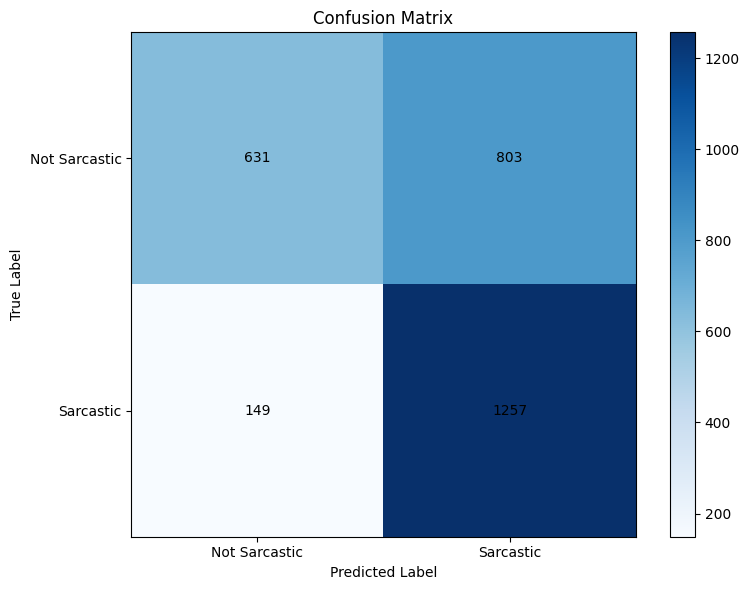

In [17]:
import matplotlib.pyplot as plt
# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)  # Assuming you have binary classification (0 and 1)
plt.xticks(tick_marks, ['Not Sarcastic', 'Sarcastic'])
plt.yticks(tick_marks, ['Not Sarcastic', 'Sarcastic'])

# Add counts in each cell
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha='center', va='center', color='black')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [20]:
y_test.shape

(2840,)

In [21]:
y_pred.shape

AttributeError: 'TFSequenceClassifierOutput' object has no attribute 'shape'

In [22]:
from sklearn.metrics import classification_report
# Generate the classification report


class_report = classification_report(y_test, y_pred_labels, target_names=['Not Sarcasm', 'Sarcasm'])

# Print the classification report
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

 Not Sarcasm       0.81      0.44      0.57      1434
     Sarcasm       0.61      0.89      0.73      1406

    accuracy                           0.66      2840
   macro avg       0.71      0.67      0.65      2840
weighted avg       0.71      0.66      0.65      2840



In [23]:
# Save the model
model.save_pretrained("distilbert_model")


In [24]:
from transformers import TFDistilBertForSequenceClassification

# Load the model
loaded_model = TFDistilBertForSequenceClassification.from_pretrained("distilbert_model")

Some layers from the model checkpoint at distilbert_model were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert_model and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
# predictive System
def predict(text):
    text = clean_tweet(text)
    # Tokenize, pad, and encode the input text
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="tf")
    
    # Predict labels for the input text
    logits = loaded_model(inputs).logits
    
    # Convert logits to probabilities
    probabilities = tf.nn.softmax(logits, axis=1).numpy()
    
    # Get predicted labels
    predicted_labels = np.argmax(probabilities, axis=1)
    
    return predicted_labels

In [26]:
# Example usage
text = '"نصيحه ما عمرك اتنزل لعبة سوبر ماريو مش زي ما كنّا متوقعين الله يرحم ايامات السيقا والفاميلي '
predicted_label = predict(text)
print("Predicted label:", predicted_label)

if predicted_label[0]==1:
    print("Sarcasm Statement")
else:
    print("Not Sarcasm Statement")

Predicted label: [1]
Sarcasm Statement


In [27]:
# Example usage 2
text = '"كل معرضينك باعوك يا سيسي '
predicted_label = predict(text)
print("Predicted label:", predicted_label)

if predicted_label[0]==1:
    print("Sarcasm Statement")
else:
    print("Not Sarcasm Statement")

Predicted label: [1]
Sarcasm Statement
